In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, multivariate_normal, norm
from scipy.optimize import minimize
import copy, os
from tutorialObjs import World, UserModel, Assistant, exp_normalize, run_task

## Easy Navigation
* [Solutions](#solutions)
    * [Task 1: Implement user model](#task1)
    * [Task 2: Implement param inference](#task2)
    * [Task 3: Implement interaction loop](#task3)
* [Results](#results)

# Collaborative modelling, design and decision making with AI, Part II <a class="anchor" id="title"></a>

Elena Shaw, Ali Khoshvishkaie, Sebastiaan De Peuter, Alex Hämäläinen, Samuel Kaski

# Solutions <a class="anchor" id="solutions"></a>

In [ ]:
task = World()

## Task 1: Implement the user model <a class="anchor" id="task1"></a>

Completing this task required implementing the following function:
$$
\exp \Big \{ - \boldsymbol{\beta} \cdot \text{cost}(\text{p}) \Big \}
$$
where $\boldsymbol{\beta}$ is the user specific parameter vector and p is the segment properties.

Common missing components:
- the negative sign: the note book displayed the equation for utility, but the implementation was about cost. As cost is the complement of utility, there needed to be a negative sign. See slide 11 of the presentation.
- the exponent: Boltzmann rationality specifically models user decision as scaled by an exponent. In the test case below, the minute differences among the 3 test paths become indistinguishable within this computational model.

In [3]:
def boltzmann_policy(all_paths,beta):
    """
    Args:
      all_paths (type `list(tuple)`): 
          The list of valid paths being considered by the user.
          
          Example: [[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
                    [(7, 0, 3), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
                    [(7, 0, 4), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)]]
          
      beta (type `numpy.array`):
          The vector of the user's hidden preference parameter.
          
          Example: np.array([0.05, 0.3, 0.65])

    Returns:
      tuple(all_paths, action_probabilities)
      
      all_paths (type `list`): 
          Same as the input.
          
      path_probabilities (type `list(numeric)` or `numpy.array`): 
          The probabilities (pmf) of selecting the corresponding path as calculated
          according to Boltzmann rationality. Note that this has been normalized
          to sum to 1 for you, so that the output is a proper distribution.
          
          Example: [.5,.2,.3] or np.array([.5,.2,.3])
    """    
    all_costs =[]
    for path in all_paths:
        path_properties = np.array([task.look_up_cost(edge) for edge in path])
        
        # Task 1 solution:
        path_costs = [np.exp(-beta.dot(p)) for p in path_properties]
        
        journey_cost = np.sum(path_costs)
        all_costs.append(journey_cost)

    path_probabilities = exp_normalize(all_costs) 
        
    return all_paths, path_probabilities

In [4]:
# run this cell to test if your function behaves correctly
test_params = np.array([1,1,1])
test_paths = [[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
              [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
              [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]]
expected_probs = np.array([1,1,1])/3
paths, probs = boltzmann_policy(test_paths,test_params)

assert paths == test_paths, f"output actions {paths} don't match the input actions {test_paths}"
assert np.allclose(probs,expected_probs), f"expected:{expected_probs}, got:{probs}"

## Task 2: Implement the user inference <a class="anchor" id="task2"></a>

There were two potential implementations for this:
- Option 1: direct use of `scipy` distributions 
- Option 2: implenting your own log probabilities
    - Note that for this option, the original test case did not take constants into account. This has since been changed.
   
\begin{align*}
\log(\boldsymbol{\beta}) &= -\frac{3}{2} \log(2\pi) -\frac{1}{2} \boldsymbol{\beta}^{\intercal} \boldsymbol{\beta}\\
\log(a_t|\boldsymbol{\beta}) &= \boldsymbol{\beta}^{\intercal} \text{Cost}(a_i)\\
\log(\boldsymbol{\beta}|a_t) &= \log(a_t|\boldsymbol{\beta}) + \log(\boldsymbol{\beta})
\end{align*}

The original test case only account for the option 1 solution, but has now been expanded to include the second options as well.

In [10]:
def posterior_update(beta,e_properties):
    """
    Args:
      beta (type `numpy.array`): 
          The 3-dimensional parameter vector representing the user's hidden preferences.
          
      e_properties (type `numpy.array`):
          The 3-dimensional parameter vector containing the properties of an edge.

    Returns:
      posterior (type `numeric`): 
          The calculated posterior/log-posterior used for inference on beta.
    """ 
    # Task 2 solution Option 1:
    log_prior = multivariate_normal(mean=np.zeros(3),  
                                    cov=np.eye(3)).logpdf(beta)
    # Task 2 solution Options 2:
    log_prior = -3/2 * np.log(2*np.pi) - .5 * beta.dot(beta)
    
    """
    Note: the solution below is mathematically valid, but causes 
          instability in the numerical optimization method 
          used below, so only the exact probabilities will work.
    """
#     log_prior = beta.dot(beta)
    
    log_likelihood = beta.dot(e_properties) 
    
    posterior = log_prior + log_likelihood
    return -1 * posterior

In [11]:
posterior = posterior_update(np.array([1,1,1]), np.array([3,5,1]))
expected_output = -4.7431844003859815
assert np.isclose(expected_output,posterior) or \
np.isclose(np.exp(expected_output),posterior) or \
np.isclose(-12,posterior),\
f'\n expected:{expected_output} or {np.exp(expected_output)} \n \
got: {posterior}' 

**Bonus excercise**:

This exercise was optional due to the sensitive nature of the numerical optimization method used here. From testing, `minimize` behaved best when $\hat{\boldsymbol{\beta}}$ was normalized, as well as when the log posterior function was exact. These were purely implementation choices, so you were not expected to have inferred this. 

**The original tests did not account for these implementational differences causing optimization instability.** It's not immediately obvious how we can handle test cases like these and still have a function that works with the hidden objects we've implmented. Further development for this will be necessary.

In [12]:
def inference_engine(e_properties,prev_distribution):
    """
    Args:
      e_properties (type `numpy.array`):
          The 3-dimensional parameter vector containing the properties of an edge.
      prev_distribution of type `scipy.stats.distribution`:
          The distribution at time t-1; used in case optimization does not succeed.

    Returns:
      approx_posterior (type `scipy.stats.distribution`): 
          The Laplace approximate distribution of the posteior/log-posterior
    """ 
    init_mean = multivariate_normal(mean=np.zeros(3),cov=np.eye(3)).rvs(1)
    optim = minimize(posterior_update, init_mean,
                     args=(e_properties,), method='BFGS')
    
    # Bonus exercise solution:
    b_hat = optim.x/np.sum(optim.x) # implementation problem: if not normalized, optim. algorithm produces errors
    H = np.linalg.inv(optim.hess_inv)
    
    if optim.success:
        approx_posterior = multivariate_normal(mean=b_hat,cov=np.abs(H))
        return approx_posterior 
    
    else:
        return prev_distribution

In [13]:
np.random.seed(seed=12345)
inf_output = inference_engine(np.array([1,3,21]),None)
if inf_output is None:
    print("Due to instability, we're currently unable to test your implementation")
else:
    sample = inf_output.rvs(size=1)
    assert sample.shape[0] == 3

    expected_mean = [0.03999997, 0.12000005, 0.83999998]

    assert np.allclose(inf_output.mean,expected_mean)
    assert np.allclose(inf_output.cov,np.eye(3),atol=1e-6), \
            f"{os.linesep}expected: {os.linesep} {np.eye(3)}, \
              {os.linesep}got:{os.linesep} {inf_output.cov}"


## Task 3: Implement the AI-user interaction <a class="anchor" id="task3"></a>

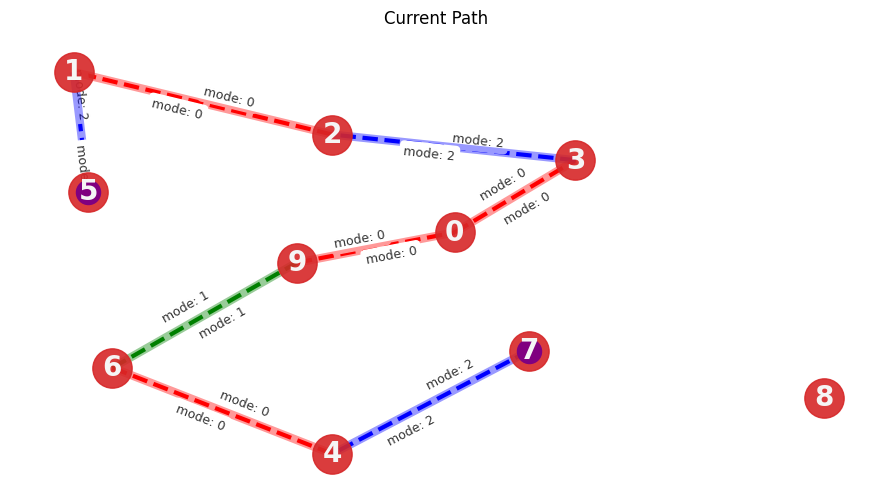

None

Congratulations! You have successfully solved the task.


In [15]:
from IPython import display
%matplotlib inline
plt.rcParams['figure.figsize'] = [11, 6]

anonUser = UserModel(simUser=False)
model_overwrites = dict(policy_fn = boltzmann_policy,
                        posterior_fn = posterior_update)

simulatedUser = UserModel(**model_overwrites)

ai_overwrites = dict(user_model = simulatedUser)
myAssistant = Assistant(**ai_overwrites)

task.reset()
while not task.is_solved():

    # Step 0) Both agents must observe the current state of the task
    myAssistant.observe(task)
    anonUser.observe(task)

    # Step 1a) The assistant gives a recommendation
    ai_rec = myAssistant.take_action()
    
    # Step 1b) The task is updated with the recommendation
    task.step(ai_action = ai_rec)
    
    # Show AI action
    display.clear_output(wait=True)
    display.display(task.display_path())
    plt.pause(.5)

    # Step 2) The user observes the action taken by the AI
    anonUser.observe(task)
    
    # Step 3a) The user proposes counter journey or agrees to the recommendation
    user_resp = anonUser.take_action()
    # Step 3b) The task is updated with the user feedback
    task.step(user_action = user_resp)
    
    # Show both AI and user actions
    display.clear_output(wait=True)
    display.display(task.display_path())
    plt.pause(0.5)
    
    
print("Congratulations! You have successfully solved the task.")

# Conclusions: Method comparison <a class="anchor" id="results"></a>

Is this user model based strategy effective? The cell below runs 100 tests comparing how long it takes (as measured by the number of interactions) the AI and user must take to solve the task together.

- "user_model" is the strategy you've implemented above
- "global_min" does not learn a user model but only searches for the observed (global) minimum
- "random" selects any valid path and mode completely randomly

In [16]:
# It can take 5-10 mins to run 100 loops, so choose your num_of_runs carefully
num_of_runs = 100
count_history = dict(user_model = [],
                     global_min = [],
                     random = [])
for i in range(num_of_runs):
    
    total_interactions = run_task()
    count_history["user_model"].append(total_interactions)
    
    total_interactions = run_task("global_min")
    count_history["global_min"].append(total_interactions)
    
    total_interactions = run_task("random")
    count_history["random"].append(total_interactions)
    
    if i%10 == 1:
        print(f"Progress: {round(i/num_of_runs,3)}")
    
print("Test means: ", {mtd: np.mean(c) for mtd,c in count_history.items()})
print("Test quantiles: ", {mtd: np.quantile(c,[.05,.5,.95]) for mtd,c in count_history.items()})
print("Test standard deviations: ", {mtd: np.std(c) for mtd,c in count_history.items()})

Progress: 0.01
Progress: 0.11
Progress: 0.21
Progress: 0.31
Progress: 0.41
Progress: 0.51
Progress: 0.61
Progress: 0.71
Progress: 0.81
Progress: 0.91
Test means:  {'user_model': 3.31, 'global_min': 4.13, 'random': 5.22}
Test quantiles:  {'user_model': array([1., 3., 9.]), 'global_min': array([ 1.,  3., 13.]), 'random': array([ 1.,  4., 16.])}
Test standard deviations:  {'user_model': 2.4927695441014994, 'global_min': 3.8096062788692486, 'random': 4.399045350982416}


Your results should show that the "user_model" strategy implemented in this tutorial is the most effective cooperation strategy, as it is the only strategy which considers the type of user it is interacting with. 

The performance against the "random" strategy baseline should be quite straightforward: on average, using a heauristic to solve a task is more efficient than randomly proposing solutions. Comparison against the "global_min" case warrents closer inspection. 

Inuitively, you can think of the "global_min" agent as one which does not bother to understand the type of user it is interacting with, but instead, operates under its own assumptions about the relative trade offs among the three properties. In this case, it is equivalent to setting the preference weights on the three properties to be constant regardless of the user. As a result, when this AI interacts with diverse types of users, this assumption will make cooperation less efficient. Instead, maintaining and strategizing the next best action via a user model can help both agents solve the task quicker.